In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.1 MB/s eta 0:00:00


In [ ]:
pip install google-colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#"C:\Users\Nathaniel Havim\My Drive\Data"

Mounted at /content/drive


In [ ]:
#importing packages
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

#data processing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

# importing models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
import xgboost as xgb
from catboost import CatBoostClassifier
#import lightgbm as lgb

#Evaluation metrics
from sklearn.metrics import roc_auc_score,log_loss


import warnings
warnings.filterwarnings('ignore')

# Other packages
from joblib import dump
import os

In [ ]:
# Now you can use the data_file_path variable to access the data file

# Load the data file using the data_file_path
customer_data = pd.read_csv(r'/content/drive/MyDrive/Data/Train.csv')

pd.set_option('display.max_columns',None)

# Now you can work with the loaded data
# For example, you can print the first few rows
customer_data.head()


,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,7ee9e11e342e27c70455960acc80d3f91c1286d1,DAKAR,K > 24 month,20000.0,47.0,21602.0,7201.0,52.0,8835.0,3391.0,396.0,185.0,NaN,NaN,NO,62,On net 200F=Unlimited _call24H,30.0,0
1,50443f42bdc92b10388fc56e520e4421a5fa655c,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,3,NaN,NaN,0
2,da90b5c1a9b204c186079f89969aa01cb03c91b2,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,1,NaN,NaN,0
3,364ec1b424cdc64c25441a444a16930289a0051e,SAINT-LOUIS,K > 24 month,7900.0,19.0,7896.0,2632.0,25.0,9385.0,27.0,46.0,20.0,NaN,2.0,NO,61,"Data:490F=1GB,7d",7.0,0
4,d5a5247005bc6d41d3d99f4ef312ebb5f640f2cb,DAKAR,K > 24 month,12350.0,21.0,12351.0,4117.0,29.0,9360.0,66.0,102.0,34.0,NaN,NaN,NO,56,All-net 500F=2000F;5d,11.0,0


Long-term: Includes tenures greater than 24 months.\
Medium-term: Includes tenures ranging from 18 to 24 months.\
Mid-term: Includes tenures ranging from 12 to 18 months.\
Short-term: Includes tenures ranging from 6 to 12 months.\
Very short-term: Includes tenures less than 6 months.


In [ ]:
tenure_mapping_cat = {
    'K > 24 month': 'Long-term',
    'E 6-9 month': 'Short-term',
    'H 15-18 month': 'Mid-term',
    'G 12-15 month': 'Mid-term',
    'I 18-21 month': 'Medium-term',
    'J 21-24 month': 'Medium-term',
    'F 9-12 month': 'Short-term',
    'D 3-6 month': 'Very short-term'
}
# Map the values using the dictionary
customer_data['TENURE'] = customer_data['TENURE'].map(tenure_mapping_cat)

The reasoning behind the mapping is as follows:

Voice: Categories such as 'On net', 'All-net', 'IVR', 'Mixt', 'CVM', 'Pilot', 'YMGX', 'Incoming', 'EVC', 'Staff', '305155009', 'pack', 'Postpaid', '301765007' primarily involve voice-related services, including voice calls and voice-based interactions.

Data: Categories starting with 'Data' indicate data-related services, which involve data usage, data packages, or data allowances.

Social Media: Categories like 'Twter' and 'Facebook' are associated with specific social media platforms.

Value Added Service: Categories such as 'VAS', 'MROMO', 'Jokko', 'FIFA', 'APANews' represent various value-added services provided by the telecom company. These services can include entertainment, news, promotions, and other additional features.

International: Categories starting with 'Internat' indicate international services or packages.

Messaging: The category 'SMS Max' represents messaging services or SMS-related packages.

By mapping the categories to these supercategories, you can simplify the analysis and grouping of services based on broader categories. This can help in identifying patterns, analyzing service usage, and making data-driven decisions related to specific service categories.


In [ ]:
voice =['On net 200F=Unlimited _call24H','All-net 500F=2000F;5d','On-net 500=4000,10d','On-net 500F_FNF;3d','On-net 300F=1800F;3d'
         'On-net 200F=60mn;1d','On net 200F= 3000F_10Mo ;24H','On-net 1000F=10MilF;10d','MIXT:500F= 2500F on net _2500F off net;2d',
         'MIXT: 390F=04HOn-net_400SMS_400 Mo;4h\t','MIXT: 200mnoff net _unl on net _5Go;30d','MIXT: 590F=02H_On-net_200SMS_200 Mo;24h\t\t',
         'MIXT:10000F=10hAllnet_3Go_1h_Zone3;30d\t\t','MIXT: 5000F=80Konnet_20Koffnet_250Mo;30d\t\t','Mixt : 500F=2500Fonnet_2500Foffnet ;5d','200F=10mnOnNetValid1H',
         '500=Unlimited3Day','150=unlimited pilot auto','CVM_100F_unlimited','CVM_100f=200 MB','CVM_100f=500 onNet','CVM_150F_unlimited',
         'CVM_200f=400MB','CVM_500f=2GB','CVM_On-net 400f=2200F','CVM_On-net 1300f=12500','EVC_100Mo','EVC_1Go','EVC_4900=12000F','EVC_500=2000F','EVC_700Mo',
         'EVC_JOKKO30','EVC_Jokko_Weekly','FNF2 ( JAPPANTE)','GPRS_3000Equal10GPORTAL','GPRS_PKG_5GO_ILLIMITE''NEW_CLIR_PERMANENT_LIBERTE_MOBILE',
         'NEW_CLIR_TEMPALLOWED_LIBERTE_MOBILE','Pilot_Youth1_290','Pilot_Youth4_490','Postpaid FORFAIT 10H Package','Staff_CPE_Rent','SUPERMAGIK_1000','SUPERMAGIK_5000',
         'WIFI_ Family _10MBPS','WIFI_ Family _4MBPS','YMGX 100=1 hour FNF, 24H/1 month','YMGX on-net 100=700F, 24H','Yewouleen_PKG','301765007','305155009',
        'Mixt 250F=Unlimited_call24H','All-net 500F =2000F_AllNet_Unlimited','All-net 600F= 3000F ;5d','On-net 200F=60mn;1d','200=Unlimited1Day',
        'All-net 1000=5000;5d', 'All-net 1000F=(3000F On+3000F Off);5d','All-net 500F=1250F_AllNet_1250_Onnet;48h','On-net 300F=1800F;3d',
        'MIXT:1000F=4250 Off net _ 4250F On net _100Mo; 5d','CVM_on-net bundle 500=5000', 'All-net 300=600;2d','IVR Echat_Weekly_200F',
        'MIXT: 500F=75(SMS, ONNET, Mo)_1000FAllNet;24h\t\t','On-net 2000f_One_Month_100H; 30d','TelmunCRBT_daily','pilot_offer6',
        'All-net 5000= 20000off+20000on;30d', 'All-net 500F=4000F ; 5d','Incoming_Bonus_woma', '1000=Unlimited7Day','MIXT: 4900F= 10H on net_1,5Go ;30d',
       'pilot_offer4','All-net 500= 4000off+4000on;24H','1500=Unlimited7Day','200=unlimited pilot auto']
customer_data['TOP_PACK'] = np.where(customer_data['TOP_PACK'].isin(voice), 'voice', customer_data['TOP_PACK'])


data_services = ['Data','DataPack_Incoming','Data_EVC_2Go24H','Data_Mifi_20Go','Data_Mifi_10Go_Monthly','Data:490F=1GB,7d','Data: 100 F=40MB,24H',
                'Data:3000F=10GB,30d','Data:200F=Unlimited,24H','Data:1000F=2GB,30d','Data:200 F=100MB,24H','Data:700F=1.5GB,7d','Data:1000F=5GB,7d','Data:700F=1.5GB,7d',
                'Data:150F=SPPackage1,24H','Data:1500F=3GB,30D','Data:300F=100MB,2d','Data:500F=2GB,24H','Data: 490F=Night,00H-08H',
                'Data:DailyCycle_Pilot_1.5GB','Data:50F=30MB_24H','Data:700F=SPPackage1,7d','Data: 200F=1GB,24H','Data:OneTime_Pilot_1.5GB''Data:1500F=3GB,30D',
                'Data:300F=100MB,2d','Data:500F=2GB,24H','Data: 490F=Night,00H-08H','Data: 200 F=100MB,24H','Data:1500F=SPPackage1,30d',
                'WIFI_Family_2MBPS','Data:OneTime_Pilot_1.5GB']
customer_data['TOP_PACK'] = np.where(customer_data['TOP_PACK'].isin(data_services), 'data', customer_data['TOP_PACK'])


vas_services = ['IVR Echat_Daily_50F','IVR Echat_Monthly_500F','VAS(IVR_Radio_Daily)','VAS(IVR_Radio_Monthly)','VAS(IVR_Radio_Weekly)',
                'MROMO_TIMWES_RENEW','MROMO_TIMWES_OneDAY', 'Jokko_Daily','Jokko_Monthly','Jokko_promo','FIFA_TS_daily',
                'FIFA_TS_weekly','APANews_weekly','APANews_monthly','Jokko_Weekly','Data:30Go_V 30_Days']
customer_data['TOP_PACK'] = np.where(customer_data['TOP_PACK'].isin(vas_services), 'value_added_services', customer_data['TOP_PACK'])


social_media_services =['Twter_U2opia_Daily','Twter_U2opia_Weekly','Twter_U2opia_Monthly','Facebook_MIX_2D']
customer_data['TOP_PACK'] = np.where(customer_data['TOP_PACK'].isin(social_media_services), 'social_media', customer_data['TOP_PACK'])


international_services = ['Internat: 1000F_Zone_1;24H','Internat: 1000F_Zone_3;24h','Internat: 2000F_Zone_2;24H','Internat: 1000F_Zone_1;24H\t\t',
                          'Internat: 1000F_Zone_3;24h\t\t','Internat: 2000F_Zone_2;24H\t\t']
customer_data['TOP_PACK'] = np.where(customer_data['TOP_PACK'].isin(international_services), 'international', customer_data['TOP_PACK'])


messaging_services = ['SMS Max','messaging']
customer_data['TOP_PACK'] = np.where(customer_data['TOP_PACK'].isin(messaging_services), 'messaging', customer_data['TOP_PACK'])


other_services =[ 'New_YAKALMA_4_ALL','FNF_Youth_ESN','GPRS_PKG_5GO_ILLIMITE','NEW_CLIR_PERMANENT_LIBERTE_MOBILE','pack_chinguitel_24h']
customer_data['TOP_PACK'] = np.where(customer_data['TOP_PACK'].isin(other_services), 'other_services', customer_data['TOP_PACK'])


In [ ]:
customer_data['TOP_PACK'].unique()

array(['voice', nan, 'data', 'value_added_services', 'social_media',
       'other_services', 'international', 'messaging'], dtype=object)

In [ ]:
#checking the shape of the dataset
print('Number of rows ',customer_data.shape[0])
print('Number of columns ',customer_data.shape[1])

Number of rows  1077024
Number of columns  19


In [ ]:
#checking the data-types of all features
customer_data.dtypes

user_id            object
REGION             object
TENURE             object
MONTANT           float64
FREQUENCE_RECH    float64
REVENUE           float64
ARPU_SEGMENT      float64
FREQUENCE         float64
DATA_VOLUME       float64
ON_NET            float64
ORANGE            float64
TIGO              float64
ZONE1             float64
ZONE2             float64
MRG                object
REGULARITY          int64
TOP_PACK           object
FREQ_TOP_PACK     float64
CHURN               int64
dtype: object

In [ ]:
#the summary of all numerical variables
customer_data.describe().T

,count,mean,std,min,25%,50%,75%,max
MONTANT,699139.0,5529.210895,7104.737952,20.0,1000.0,3000.0,7350.0,470000.0
FREQUENCE_RECH,699139.0,11.523756,13.261938,1.0,2.0,7.0,16.0,131.0
REVENUE,714669.0,5506.050798,7175.625010,1.0,1000.0,3000.0,7360.0,532177.0
ARPU_SEGMENT,714669.0,1835.355961,2391.870902,0.0,333.0,1000.0,2453.0,177392.0
FREQUENCE,714669.0,13.974439,14.687059,1.0,3.0,9.0,20.0,91.0
DATA_VOLUME,547261.0,3368.801722,12898.928039,0.0,0.0,258.0,2905.0,1702309.0
ON_NET,683850.0,277.065798,874.315378,0.0,5.0,27.0,156.0,50809.0
ORANGE,629880.0,95.160804,203.020261,0.0,7.0,29.0,99.0,12040.0
TIGO,432250.0,23.105018,64.035464,0.0,2.0,6.0,20.0,4174.0
ZONE1,84898.0,8.167483,39.245883,0.0,0.0,1.0,3.0,2507.0


In [ ]:
customer_data.drop(["user_id","MRG"],axis=1, inplace=True)

## Feature Processing & Engineering
Here is the section to clean, process the dataset and create new features.

In [ ]:
#splitting data into train and validation data
X_train,X_validation,y_train,y_validation = train_test_split(customer_data.iloc[:, :-1], customer_data.iloc[:, -1:],
                                                    test_size=0.2, random_state=42, stratify=customer_data.iloc[:, -1:])

In [ ]:
X_train.shape,X_validation.shape,y_train.shape,y_validation.shape

((861619, 16), (215405, 16), (861619, 1), (215405, 1))

In [ ]:
#Checking for duplicates in the dataset
train_duplicate = X_train.duplicated()
validation_duplicate =X_validation.duplicated()
print("Number of train duplicates: ", train_duplicate.sum())
print("Number of validation duplicate: ",validation_duplicate.sum())

Number of train duplicates:  252811
Number of validation duplicate:  59667


In [ ]:
# Removing duplicates and keeping the first instance
X_train = X_train.drop_duplicates(keep='first')
y_train = y_train[train_duplicate == False]

X_validation = X_validation.drop_duplicates(keep='first')
y_validation = y_validation[validation_duplicate == False]
# Checking for duplicates in the filtered datasets
train_duplicates_remaining = X_train.duplicated().sum()
validation_duplicates_remaining = X_validation.duplicated().sum()

print("Number of train duplicates remaining: ", train_duplicates_remaining)
print("Number of validation duplicates remaining: ", validation_duplicates_remaining)


Number of train duplicates remaining:  0
Number of validation duplicates remaining:  0


In [ ]:
# Check for missing values in data
train_missing_values = X_train.isnull().sum()
print("missing values in train data:",train_missing_values)

missing values in train data: REGION            138748
TENURE                 0
MONTANT            56410
FREQUENCE_RECH     56410
REVENUE            43545
ARPU_SEGMENT       43545
FREQUENCE          43545
DATA_VOLUME       197540
ON_NET             78663
ORANGE            105748
TIGO              263026
ZONE1             541221
ZONE2             553916
REGULARITY             0
TOP_PACK          108543
FREQ_TOP_PACK     108543
dtype: int64


In [ ]:
validation_missing_values = X_validation.isnull().sum()
print("missing values un validation data:",validation_missing_values)

missing values un validation data: REGION             36531
TENURE                 0
MONTANT            17418
FREQUENCE_RECH     17418
REVENUE            13994
ARPU_SEGMENT       13994
FREQUENCE          13994
DATA_VOLUME        51856
ON_NET             21763
ORANGE             30116
TIGO               69388
ZONE1             138832
ZONE2             141854
REGULARITY             0
TOP_PACK           30584
FREQ_TOP_PACK      30584
dtype: int64


## Imputting Missing Values

In [ ]:
#making a list of the numerical features
num_columns = [col for col in X_train.columns if X_train[col].dtype != 'object']

In [ ]:
#imputing missing values.
numerical_imputer= SimpleImputer(strategy= "median")

In [ ]:
#transforming
X_train_imputed = numerical_imputer.fit_transform(X_train[num_columns])
X_eval_imputed = numerical_imputer.transform(X_validation[num_columns])

In [ ]:
#list of the catehorical features
cat_columns = [col for col in X_train.columns if X_train[col].dtype == 'object']

In [ ]:
cat_imputer = SimpleImputer(strategy= "most_frequent")

In [ ]:
#transform
X_train_cat_imputed = cat_imputer.fit_transform(X_train[cat_columns])
X_eval_cat_imputed = cat_imputer.transform(X_validation[cat_columns])

## Encoding

In [ ]:
#instanciating the onehotencoder
encoder = OneHotEncoder(handle_unknown='ignore')

X_train_encoded =pd.DataFrame(encoder.fit_transform(X_train_cat_imputed).toarray(),
                                   columns=encoder.get_feature_names_out(cat_columns))

X_validation_encoded =pd.DataFrame(encoder.transform(X_eval_cat_imputed).toarray(),
                                   columns=encoder.get_feature_names_out(cat_columns))

## Feature scalling

In [ ]:
# instanciating the scaler
scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed),columns =num_columns)
X_validation_scaled = pd.DataFrame(scaler.transform(X_eval_imputed),columns =num_columns)

## Combining dataframe

In [ ]:
Xtrain = pd.concat([X_train_scaled, X_train_encoded], axis=1)

Xeval = pd.concat([X_validation_scaled, X_validation_encoded], axis=1)

In [ ]:
Xtrain.head()

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK,REGION_DAKAR,REGION_DIOURBEL,REGION_FATICK,REGION_KAFFRINE,REGION_KAOLACK,REGION_KEDOUGOU,REGION_KOLDA,REGION_LOUGA,REGION_MATAM,REGION_SAINT-LOUIS,REGION_SEDHIOU,REGION_TAMBACOUNDA,REGION_THIES,REGION_ZIGUINCHOR,TENURE_Long-term,TENURE_Medium-term,TENURE_Mid-term,TENURE_Short-term,TENURE_Very short-term,TOP_PACK_data,TOP_PACK_international,TOP_PACK_messaging,TOP_PACK_other_services,TOP_PACK_social_media,TOP_PACK_value_added_services,TOP_PACK_voice
0,0.006553,0.046154,0.005673,0.005677,0.088889,0.000282,0.000590,0.002409,0.001437,0.000399,0.000541,0.032787,0.006421,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.011235,0.092308,0.009961,0.009961,0.177778,0.006189,0.000590,0.000332,0.000000,0.000399,0.000541,0.032787,0.009631,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001021,0.000000,0.000938,0.000941,0.000000,0.000101,0.000197,0.000581,0.001437,0.000399,0.000541,0.213115,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.010596,0.061538,0.009394,0.009397,0.088889,0.000282,0.005491,0.002907,0.003594,0.000399,0.000541,0.770492,0.009631,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.006553,0.046154,0.000036,0.000039,0.000000,0.000282,0.000590,0.000000,0.001437,0.000399,0.000541,0.000000,0.006421,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
Xeval.head()

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK,REGION_DAKAR,REGION_DIOURBEL,REGION_FATICK,REGION_KAFFRINE,REGION_KAOLACK,REGION_KEDOUGOU,REGION_KOLDA,REGION_LOUGA,REGION_MATAM,REGION_SAINT-LOUIS,REGION_SEDHIOU,REGION_TAMBACOUNDA,REGION_THIES,REGION_ZIGUINCHOR,TENURE_Long-term,TENURE_Medium-term,TENURE_Mid-term,TENURE_Short-term,TENURE_Very short-term,TOP_PACK_data,TOP_PACK_international,TOP_PACK_messaging,TOP_PACK_other_services,TOP_PACK_social_media,TOP_PACK_value_added_services,TOP_PACK_voice
0,0.000383,0.000000,0.005673,0.005677,0.088889,0.000282,0.000590,0.002409,0.001437,0.000399,0.000541,0.000000,0.006421,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.006553,0.046154,0.005673,0.005677,0.088889,0.000282,0.000590,0.002409,0.001437,0.000399,0.000541,0.016393,0.006421,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.032938,0.146154,0.027241,0.027245,0.311111,0.000282,0.006141,0.008970,0.015812,0.000399,0.000541,0.983607,0.035313,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.002511,0.038462,0.002255,0.002255,0.177778,0.000282,0.000236,0.000332,0.000000,0.000399,0.000541,0.688525,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.006553,0.061538,0.005820,0.005823,0.100000,0.000282,0.001397,0.004070,0.003594,0.000399,0.000541,0.721311,0.004815,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
Xtrain.shape,Xeval.shape

((608808, 39), (155738, 39))

## Machine Learning Modeling
Here is a section to build,train,evaluate and compare models with each other.

#### Evaluation Matrics
LOG-LOSS
Log-loss is indicative of how close the prediction probability is to the corresponding actual/true value (0 or 1 in case of binary classification), penalizing inaccurate predictions with higher values. Lower log-loss indicates better model performance.
Log Loss is the most important classification metric based on probabilities

AUC_SCORE
The AUC score, short for Area Under the Curve, is a widely used metric for evaluating binary classification models. It measures the model's ability to distinguish between positive and negative samples by calculating the area under the Receiver Operating Characteristic (ROC) curve.

## Training with Imbalanced dataset

## Simple Model #1

In [ ]:
#defining and fitting the model
lr_model = LogisticRegression()
lr_model.fit(Xtrain,y_train)

LogisticRegression()

In [ ]:
# Make predictions
lr_probabilities =lr_model.predict_proba(Xeval)
lr_preds = lr_model.predict(Xeval)

In [ ]:
#Evaluating the models performance
# Calculate the ROC AUC score
auc_score = roc_auc_score(y_validation,lr_preds)

# Calculate the log loss
logloss = log_loss(y_validation,lr_probabilities)

print('The models AUC_score is: ',auc_score)
print('The models probability is: ',logloss)

The models AUC_score is:  0.5019502974994821
The models probability is:  0.16615878804102432


## Simple model #2

In [ ]:
rf_model =  RandomForestClassifier(random_state =42)
rf_model.fit(Xtrain,y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# making prediction
rf_probabilities = rf_model.predict_proba(Xeval)
rf_preds = rf_model.predict(Xeval)

In [ ]:
#Evaluating model performance
# Calculate the ROC AUC score
rf_auc_score = roc_auc_score(y_validation,rf_preds)

# Calculate the log loss
rf_logloss = log_loss(y_validation,rf_probabilities)

print('The models AUC_score is: ',rf_auc_score)
print('The models probability is: ',rf_logloss)

The models AUC_score is:  0.5740564292834717
The models probability is:  0.25672761707713304


## Simple model #3

In [ ]:
dt_model = DecisionTreeClassifier()
dt_model.fit(Xtrain,y_train)

DecisionTreeClassifier()

In [ ]:
# making prediction
dt_probabilities = dt_model.predict_proba(Xeval)
dt_preds = dt_model.predict(Xeval)

In [ ]:
#Evaluationg model performance
# Calculate the ROC AUC score
dt_auc_score = roc_auc_score(y_validation,dt_preds)

# Calculate the log loss
dt_logloss = log_loss(y_validation,dt_probabilities)

print('The models AUC_score is: ',dt_auc_score)
print('The models probability is: ',dt_logloss)

The models AUC_score is:  0.6066788666885746
The models probability is:  3.319942949976106


## Simple model #4

In [ ]:
gb_model =  GradientBoostingClassifier()
gb_model.fit(Xtrain,y_train)

GradientBoostingClassifier()

In [ ]:
# making prediction
gb_probabilities = gb_model.predict_proba(Xeval)
gb_preds = gb_model.predict(Xeval)

In [ ]:
#Evaluationg model performance
# Calculate the ROC AUC score
gb_auc_score = roc_auc_score(y_validation,gb_preds)

# Calculate the log loss
gb_logloss = log_loss(y_validation,gb_probabilities)

print('The models AUC_score is: ',gb_auc_score)
print('The models probability is: ',gb_logloss)

The models AUC_score is:  0.5416567014488735
The models probability is:  0.16095585591059336


## Simple model #5

In [ ]:
gaussian_model = GaussianNB()
gaussian_model.fit(Xtrain,y_train)

GaussianNB()

In [ ]:
# making prediction
gaussian_probabilities = gaussian_model.predict_proba(Xeval)
gaussian_preds = gaussian_model.predict(Xeval)

In [ ]:
#Evaluationg model performance
# Calculate the ROC AUC score
gaussian_auc_score = roc_auc_score(y_validation,gaussian_preds)

# Calculate the log loss
gaussian_logloss = log_loss(y_validation,gaussian_probabilities)

print('The models AUC_score is: ',gaussian_auc_score)
print('The models probability is: ',gaussian_logloss)

The models AUC_score is:  0.7467992023707091
The models probability is:  6.206523436210097


## Simple Model #6

In [ ]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(Xtrain,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
# making prediction
xgb_probabilities = xgb_model.predict_proba(Xeval)
xgb_preds = xgb_model.predict(Xeval)

In [ ]:
#Evaluationg model performance
# Calculate the ROC AUC score
xgb_auc_score = roc_auc_score(y_validation,xgb_preds)

# Calculate the log loss
xgb_logloss = log_loss(y_validation,xgb_probabilities)

print('The models AUC_score is: ',xgb_auc_score)
print('The models probability is: ',xgb_logloss)

The models AUC_score is:  0.5468647732216868
The models probability is:  0.16018894724156185


## Simple model #7

In [ ]:
# fitting catboost model with selected features
catb_model= CatBoostClassifier()
catb_model.fit(Xtrain,y_train)

Learning rate set to 0.159187
0:	learn: 0.4409889	total: 353ms	remaining: 5m 52s
1:	learn: 0.3163747	total: 634ms	remaining: 5m 16s
2:	learn: 0.2513298	total: 950ms	remaining: 5m 15s
3:	learn: 0.2167631	total: 1.24s	remaining: 5m 8s
4:	learn: 0.1950798	total: 1.53s	remaining: 5m 4s
5:	learn: 0.1808120	total: 1.81s	remaining: 5m
6:	learn: 0.1734381	total: 2.09s	remaining: 4m 57s
7:	learn: 0.1677562	total: 2.38s	remaining: 4m 55s
8:	learn: 0.1638441	total: 2.67s	remaining: 4m 54s
9:	learn: 0.1615662	total: 2.96s	remaining: 4m 52s
10:	learn: 0.1600812	total: 3.26s	remaining: 4m 52s
11:	learn: 0.1588094	total: 3.42s	remaining: 4m 41s
12:	learn: 0.1578122	total: 3.57s	remaining: 4m 30s
13:	learn: 0.1571558	total: 3.73s	remaining: 4m 22s
14:	learn: 0.1565114	total: 3.87s	remaining: 4m 14s
15:	learn: 0.1562919	total: 4.01s	remaining: 4m 6s
16:	learn: 0.1558231	total: 4.17s	remaining: 4m 1s
17:	learn: 0.1554710	total: 4.32s	remaining: 3m 55s
18:	learn: 0.1552802	total: 4.47s	remaining: 3m 50s


In [ ]:
# Make predictions
catb_probabilities =catb_model.predict_proba(Xeval)
catb_preds = catb_model.predict(Xeval)

In [ ]:
#Evaluating the models performance
# Calculate the ROC AUC score
Catb_auc_score = roc_auc_score(y_validation,catb_preds)

# Calculate the log loss
Catb_logloss = log_loss(y_validation,catb_probabilities)

print('The models AUC_score is: ',Catb_auc_score)
print('The models probability is: ',Catb_logloss)

The models AUC_score is:  0.5514173946071372
The models probability is:  0.15980924398143806


## Simple model #8

In [ ]:
cnb_model = ComplementNB()
cnb_model.fit(Xtrain,y_train)

ComplementNB()

In [ ]:
# making prediction
cnb_probabilities = cnb_model.predict_proba(Xeval)
cnb_preds = cnb_model.predict(Xeval)

In [ ]:
#Evaluationg model performance
# Calculate the ROC AUC score
cnb_auc_score = roc_auc_score(y_validation,cnb_preds)

# Calculate the log loss
cnb_logloss = log_loss(y_validation,cnb_probabilities)

print('The models AUC_score is: ',cnb_auc_score)
print('The models probability is: ',cnb_logloss)

The models AUC_score is:  0.7626310658873119
The models probability is:  0.5149520524331647


In [ ]:
#comparision
results= {'model':['Decision Tree','Random Forest','XGBoost','Logistic Regression','GaussianNB','GradientBoosting','Catboost','ComplementNB'],
         'AUC_score':[dt_auc_score,rf_auc_score,xgb_auc_score,auc_score,gaussian_auc_score,gb_auc_score,Catb_auc_score,cnb_auc_score],
         'log_loss':[dt_logloss,rf_logloss,xgb_logloss,logloss,gaussian_logloss,gb_logloss,Catb_logloss,cnb_logloss]}
results_df= pd.DataFrame(results)

In [ ]:
results_df.sort_values(by= 'AUC_score', ascending = False)

,model,AUC_score,log_loss
7,ComplementNB,0.762631,0.514952
4,GaussianNB,0.746799,6.206523
0,Decision Tree,0.606679,3.319943
1,Random Forest,0.574056,0.256728
6,Catboost,0.551417,0.159809
2,XGBoost,0.546865,0.160189
5,GradientBoosting,0.541657,0.160956
3,Logistic Regression,0.501950,0.166159


## Optional: Training with balanced Dataset


In [ ]:
# Instantiate SMOTE object
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(Xtrain, y_train)

# Verify the class distribution after applying SMOTE
print("Class distribution after applying SMOTE:")
print(y_train_smote.value_counts())


Class distribution after applying SMOTE:
CHURN
0        573485
1        573485
dtype: int64


## Sample model #1

In [ ]:
#fitting logistic regression model with balanced data.
lr_smote_model = LogisticRegression()
lr_smote_model.fit(X_train_smote,y_train_smote)

LogisticRegression()

In [ ]:
# Make predictions
lr_smote_proba = lr_smote_model.predict_proba(Xeval)
lr_smote_preds = lr_smote_model.predict(Xeval)

In [ ]:
# Calculate the ROC AUC score
lr_smote_auc_score = roc_auc_score(y_validation, lr_smote_preds)

# Calculate the log loss
lr_smote_logloss = log_loss(y_validation, lr_smote_proba)

print('The model\'s AUC score is:', lr_smote_auc_score)
print('The model\'s log loss is:', lr_smote_logloss)


The model's AUC score is: 0.8060020196456827
The model's log loss is: 0.4534433200528251


## Simple model #2

In [ ]:
#fitting random forest with balanced data
rf_smote_model = RandomForestClassifier()
rf_smote_model.fit(X_train_smote,y_train_smote)

RandomForestClassifier()

In [ ]:
# Make predictions
rf_smote_proba = rf_smote_model.predict_proba(Xeval)
rf_smote_preds = rf_smote_model.predict(Xeval)

In [ ]:
# Calculate the ROC AUC score
rf_smote_auc_score = roc_auc_score(y_validation, rf_smote_preds)

# Calculate the log loss
rf_smote_logloss = log_loss(y_validation, rf_smote_proba)

print('The model\'s AUC score is:', rf_smote_auc_score)
print('The model\'s log loss is:', rf_smote_logloss)


The model's AUC score is: 0.6602627208015098
The model's log loss is: 0.2651930748861605


## Simple model #3

In [ ]:
# fitting decision tree model with balanced data
dt_smote_model= DecisionTreeClassifier()
dt_smote_model.fit(X_train_smote,y_train_smote)

DecisionTreeClassifier()

In [ ]:
# Make predictions
dt_smote_proba = dt_smote_model.predict_proba(Xeval)
dt_smote_preds = dt_smote_model.predict(Xeval)

In [ ]:
# Calculate the ROC AUC score
dt_smote_auc_score = roc_auc_score(y_validation, dt_smote_preds)

# Calculate the log loss
dt_smote_logloss = log_loss(y_validation, dt_smote_proba)

print('The model\'s AUC score is:', dt_smote_auc_score)
print('The model\'s log loss is:', dt_smote_logloss)


The model's AUC score is: 0.6395712754550664
The model's log loss is: 4.009049247197236


## Simple model #4

In [ ]:
# fitting gradient boosting model with balanced data.
gb_smote_model = GradientBoostingClassifier()
gb_smote_model.fit(X_train_smote,y_train_smote)

GradientBoostingClassifier()

In [ ]:
# Make predictions
gb_smote_proba = gb_smote_model.predict_proba(Xeval)
gb_smote_preds = gb_smote_model.predict(Xeval)

In [ ]:
# Calculate the ROC AUC score
gb_smote_auc_score = roc_auc_score(y_validation, gb_smote_preds)

# Calculate the log loss
gb_smote_logloss = log_loss(y_validation, gb_smote_proba)

print('The model\'s AUC score is:', gb_smote_auc_score)
print('The model\'s log loss is:', gb_smote_logloss)


The model's AUC score is: 0.7988529984952449
The model's log loss is: 0.3674341191721908


## Simple model #5

In [ ]:
#fitting gaussian model with balanced data
gaussian_smote_model= GaussianNB()
gaussian_smote_model.fit(X_train_smote,y_train_smote)

GaussianNB()

In [ ]:
# Make predictions
gaussian_smote_proba = gaussian_smote_model.predict_proba(Xeval)
gaussian_smote_preds = gaussian_smote_model.predict(Xeval)

In [ ]:
# Calculate the ROC AUC score
gnb_smote_auc_score = roc_auc_score(y_validation, gaussian_smote_preds)

# Calculate the log loss
gnb_smote_logloss = log_loss(y_validation, gaussian_smote_proba)

print('The model\'s AUC score is:', gnb_smote_auc_score)
print('The model\'s log loss is:', gnb_smote_logloss)


The model's AUC score is: 0.7452130902085367
The model's log loss is: 7.93071459706189


## Simple model #6

In [ ]:
#fitting xgboost model with balanced dataset
xgb_smote_model = xgb.XGBClassifier()
xgb_smote_model.fit(X_train_smote,y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
# Make predictions
xgb_smote_proba = xgb_smote_model.predict_proba(Xeval)
xgb_smote_preds = xgb_smote_model.predict(Xeval)

In [ ]:
# Calculate the ROC AUC score
xgb_smote_auc_score = roc_auc_score(y_validation, xgb_smote_preds)
# Calculate the log loss
xgb_smote_logloss = log_loss(y_validation, xgb_smote_proba)

print('The model\'s AUC score is:', xgb_smote_auc_score)
print('The model\'s log loss is:', xgb_smote_logloss)


The model's AUC score is: 0.6886884001789987
The model's log loss is: 0.20837397012766298


## Simple model #7

In [ ]:
#fitting catboost model on balanced dataset
catb_smote_model = CatBoostClassifier()
catb_smote_model.fit(X_train_smote,y_train_smote)

Learning rate set to 0.208623
0:	learn: 0.5580262	total: 583ms	remaining: 9m 42s
1:	learn: 0.4852314	total: 992ms	remaining: 8m 15s
2:	learn: 0.4363112	total: 1.37s	remaining: 7m 34s
3:	learn: 0.4035047	total: 1.76s	remaining: 7m 18s
4:	learn: 0.3857938	total: 2.11s	remaining: 7m
5:	learn: 0.3679444	total: 2.47s	remaining: 6m 49s
6:	learn: 0.3532826	total: 2.85s	remaining: 6m 44s
7:	learn: 0.3388127	total: 3.36s	remaining: 6m 56s
8:	learn: 0.3290851	total: 3.85s	remaining: 7m 4s
9:	learn: 0.3197749	total: 4.35s	remaining: 7m 10s
10:	learn: 0.3112791	total: 4.72s	remaining: 7m 4s
11:	learn: 0.3068927	total: 5.03s	remaining: 6m 54s
12:	learn: 0.2984627	total: 5.34s	remaining: 6m 45s
13:	learn: 0.2931704	total: 5.65s	remaining: 6m 38s
14:	learn: 0.2847520	total: 5.95s	remaining: 6m 30s
15:	learn: 0.2787513	total: 6.23s	remaining: 6m 23s
16:	learn: 0.2741438	total: 6.53s	remaining: 6m 17s
17:	learn: 0.2702333	total: 6.85s	remaining: 6m 13s
18:	learn: 0.2650069	total: 7.34s	remaining: 6m 19

In [ ]:
# Make predictions
catb_smote_proba = catb_smote_model.predict_proba(Xeval)
catb_smote_preds = catb_smote_model.predict(Xeval)

In [ ]:
# Calculate the ROC AUC score
catb_smote_auc_score = roc_auc_score(y_validation, catb_smote_preds)

# Calculate the log loss
catb_smote_logloss = log_loss(y_validation, catb_smote_proba)

print('The models AUC_score is: ',catb_smote_auc_score)
print('The models probability is: ',catb_smote_logloss)

The models AUC_score is:  0.6576021141438756
The models probability is:  0.18718801438891147


## simple model #8

In [ ]:
#fitting complementNB with balanced dataset
cnb_smote_model = ComplementNB()
cnb_smote_model.fit(X_train_smote,y_train_smote)

ComplementNB()

In [ ]:
# Make predictions
cnb_smote_proba = cnb_smote_model.predict_proba(Xeval)
cnb_smote_preds = cnb_smote_model.predict(Xeval)

In [ ]:
# Calculate the ROC AUC score
cnb_smote_auc_score = roc_auc_score(y_validation, cnb_smote_preds)

# Calculate the log loss
cnb_smote_logloss = log_loss(y_validation, cnb_smote_proba)

print('The models AUC_score is: ',cnb_smote_auc_score)
print('The models probability is: ',cnb_smote_logloss)

The models AUC_score is:  0.7629451409188994
The models probability is:  0.514024333672623


In [ ]:
# comparision
results_smote= {'model':['Decision Tree','Random Forest','XGBoost','Logistic Regression','GaussianNB','GradientBoosting','CatBoost','ComplementNB'],
         'AUC_score':[dt_smote_auc_score,rf_smote_auc_score,xgb_smote_auc_score,lr_smote_auc_score,gnb_smote_auc_score,gb_smote_auc_score,catb_smote_auc_score,cnb_smote_auc_score],
         'log_loss':[dt_smote_logloss,rf_smote_logloss,xgb_smote_logloss,lr_smote_logloss,gnb_smote_logloss,gb_smote_logloss,catb_smote_logloss,cnb_smote_logloss]}

results_smote_df= pd.DataFrame(results_smote)


In [ ]:
results_smote_df.sort_values(by= 'AUC_score', ascending = False)

,model,AUC_score,log_loss
3,Logistic Regression,0.806002,0.453443
5,GradientBoosting,0.798853,0.367434
7,ComplementNB,0.762945,0.514024
4,GaussianNB,0.745213,7.930715
2,XGBoost,0.688688,0.208374
1,Random Forest,0.660263,0.265193
6,CatBoost,0.657602,0.187188
0,Decision Tree,0.639571,4.009049


## Computing VIF

Variance Inflation Factor(VIF) is a metric for gauging multicollinearity between features.The VIF directly measures the ratio of the variance of the entire model to the variance of a model with only the feature in question.

In layman’s terms, it gauges how much a feature’s inclusion contributes to the overall variance of the coefficients of the features in the model.

VIF starts at 1 and has no upper limit
VIF = 1, no correlation between the independent variable and the other variables
VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others.

In [ ]:
# Calculate VIF
vif = pd.DataFrame()
vif["Variable"] = Xtrain.columns
vif["VIF"] = [variance_inflation_factor(Xtrain.values, i) for i in range(Xtrain.shape[1])]

In [ ]:
#identifying variables with high vif
vif = vif[vif['Variable']!='intercept']
vif

,Variable,VIF
0,MONTANT,1.968539e+01
1,FREQUENCE_RECH,1.397954e+01
2,REVENUE,7.076735e+07
3,ARPU_SEGMENT,7.076553e+07
4,FREQUENCE,1.251277e+01
5,DATA_VOLUME,1.218418e+00
6,ON_NET,1.265181e+00
7,ORANGE,2.249427e+00
8,TIGO,1.313612e+00
9,ZONE1,1.134721e+00


The mistake would be to remove all features at once. Feature selection is usually best performed by including or removing one feature at a time. This ensures that any information loss is minimized.

In [ ]:
removed_features = []
while True:
    vif = pd.DataFrame()
    remaining_features = Xtrain.drop(removed_features, axis=1, errors='ignore').columns
    if len(remaining_features) == 0:
        break

    vif["Variable"] = remaining_features
    vif["VIF"] = [variance_inflation_factor(Xtrain.drop(removed_features, axis=1, errors='ignore').values, i) for i in range(len(remaining_features))]
    vif = vif[vif['Variable'] != 'intercept']

    max_vif_feature = vif.loc[vif['VIF'].idxmax(), 'Variable']
    max_vif_value = vif.loc[vif['VIF'].idxmax(), 'VIF']

    if max_vif_value <= 5:
        break

    Xtrain_vif = Xtrain.drop(max_vif_feature, axis=1)
    removed_features.append(max_vif_feature)

print("Features removed to reduce VIF:", removed_features)
print("Remaining features with VIF <= 5:")
print(vif)

Features removed to reduce VIF: ['REGION_DAKAR', 'TENURE_Long-term', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE_RECH', 'FREQUENCE']
Remaining features with VIF <= 5:
                         Variable       VIF
0                         MONTANT  3.895506
1                     DATA_VOLUME  1.188711
2                          ON_NET  1.232132
3                          ORANGE  2.105058
4                            TIGO  1.303483
5                           ZONE1  1.092757
6                           ZONE2  1.149416
7                      REGULARITY  1.492255
8                   FREQ_TOP_PACK  2.408945
9                 REGION_DIOURBEL  1.037006
10                  REGION_FATICK  1.028905
11                REGION_KAFFRINE  1.040251
12                 REGION_KAOLACK  1.065808
13                REGION_KEDOUGOU  1.000786
14                   REGION_KOLDA  1.037321
15                   REGION_LOUGA  1.073294
16                   REGION_MATAM  1.018738
17             REGION_SAINT-LOUIS  1.078358
18 

In [ ]:
Xtrain_vif = Xtrain.drop(removed_features, axis=1)

In [ ]:
Xtrain_vif.head()

,MONTANT,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK,REGION_DIOURBEL,REGION_FATICK,REGION_KAFFRINE,REGION_KAOLACK,REGION_KEDOUGOU,REGION_KOLDA,REGION_LOUGA,REGION_MATAM,REGION_SAINT-LOUIS,REGION_SEDHIOU,REGION_TAMBACOUNDA,REGION_THIES,REGION_ZIGUINCHOR,TENURE_Medium-term,TENURE_Mid-term,TENURE_Short-term,TENURE_Very short-term,TOP_PACK_data,TOP_PACK_international,TOP_PACK_messaging,TOP_PACK_other_services,TOP_PACK_social_media,TOP_PACK_value_added_services,TOP_PACK_voice
0,0.006553,0.000282,0.000590,0.002409,0.001437,0.000399,0.000541,0.032787,0.006421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.011235,0.006189,0.000590,0.000332,0.000000,0.000399,0.000541,0.032787,0.009631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001021,0.000101,0.000197,0.000581,0.001437,0.000399,0.000541,0.213115,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.010596,0.000282,0.005491,0.002907,0.003594,0.000399,0.000541,0.770492,0.009631,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.006553,0.000282,0.000590,0.000000,0.001437,0.000399,0.000541,0.000000,0.006421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
Xeval_vif = Xeval.drop(removed_features, axis=1)

In [ ]:
Xeval_vif.head()

,MONTANT,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK,REGION_DIOURBEL,REGION_FATICK,REGION_KAFFRINE,REGION_KAOLACK,REGION_KEDOUGOU,REGION_KOLDA,REGION_LOUGA,REGION_MATAM,REGION_SAINT-LOUIS,REGION_SEDHIOU,REGION_TAMBACOUNDA,REGION_THIES,REGION_ZIGUINCHOR,TENURE_Medium-term,TENURE_Mid-term,TENURE_Short-term,TENURE_Very short-term,TOP_PACK_data,TOP_PACK_international,TOP_PACK_messaging,TOP_PACK_other_services,TOP_PACK_social_media,TOP_PACK_value_added_services,TOP_PACK_voice
0,0.000383,0.000282,0.000590,0.002409,0.001437,0.000399,0.000541,0.000000,0.006421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.006553,0.000282,0.000590,0.002409,0.001437,0.000399,0.000541,0.016393,0.006421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.032938,0.000282,0.006141,0.008970,0.015812,0.000399,0.000541,0.983607,0.035313,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.002511,0.000282,0.000236,0.000332,0.000000,0.000399,0.000541,0.688525,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.006553,0.000282,0.001397,0.004070,0.003594,0.000399,0.000541,0.721311,0.004815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Optional: Training with selected Features

## Simple model #1

In [ ]:
# training logistics regression model with selected fearures
lr_model_vif= LogisticRegression()
lr_model_vif.fit(Xtrain_vif,y_train)

LogisticRegression()

In [ ]:
# Make predictions
lrprobabilities =lr_model_vif.predict_proba(Xeval_vif)
lrpreds = lr_model_vif.predict(Xeval_vif)

In [ ]:
#Evaluating the models performance
# Calculate the ROC AUC score
lr_vif_auc_score = roc_auc_score(y_validation,lrpreds)

# Calculate the log loss
lr_vif_logloss = log_loss(y_validation,lrprobabilities)

print('The models AUC_score is: ',lr_vif_auc_score)
print('The models probability is: ',lr_vif_logloss)

The models AUC_score is:  0.5019915188027227
The models probability is:  0.1662879742865947


## Simple model #2

In [ ]:
# fitting random forest withe selected features
rf_model_vif = RandomForestClassifier(random_state =42)
rf_model_vif.fit(Xtrain_vif,y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Make predictions
rfprobabilities =rf_model_vif.predict_proba(Xeval_vif)
rfpreds = rf_model_vif.predict(Xeval_vif)

In [ ]:
#Evaluating the models performance
# Calculate the ROC AUC score
rf_vif_auc_score = roc_auc_score(y_validation,rfpreds)

# Calculate the log loss
rf_vif_logloss = log_loss(y_validation,rfprobabilities)

print('The models AUC_score is: ',rf_vif_auc_score)
print('The models probability is: ',rf_vif_logloss)

The models AUC_score is:  0.5732674428619237
The models probability is:  0.28005241639812756


## Simple model #3

In [ ]:
# fitting the decision tree model with selected features
dt_model_vif = DecisionTreeClassifier()
dt_model_vif.fit(Xtrain_vif,y_train)

DecisionTreeClassifier()

In [ ]:
# Make predictions
dtprobabilities =dt_model_vif.predict_proba(Xeval_vif)
dtpreds = dt_model_vif.predict(Xeval_vif)

In [ ]:
#Evaluating the models performance
# Calculate the ROC AUC score
dt_vif_auc_score = roc_auc_score(y_validation,dtpreds)

# Calculate the log loss
dt_vif_logloss = log_loss(y_validation,dtprobabilities)

print('The models AUC_score is: ',dt_vif_auc_score)
print('The models probability is: ',dt_vif_logloss)

The models AUC_score is:  0.597113474872996
The models probability is:  3.1250022884076345


## Simple model #4

In [ ]:
#fitting the gradient boosting model with selected features
gb_model_vif = GradientBoostingClassifier()
gb_model_vif.fit(Xtrain_vif,y_train)

GradientBoostingClassifier()

In [ ]:
# Make predictions
gbprobabilities =gb_model_vif.predict_proba(Xeval_vif)
gbpreds = gb_model_vif.predict(Xeval_vif)

In [ ]:
#Evaluating the models performance
# Calculate the ROC AUC score
gb_vif_auc_score = roc_auc_score(y_validation,gbpreds)

# Calculate the log loss
gb_vif_logloss = log_loss(y_validation,gbprobabilities)

print('The models AUC_score is: ',gb_vif_auc_score)
print('The models probability is: ',gb_vif_logloss)

The models AUC_score is:  0.5461478241112684
The models probability is:  0.16365520083505555


## Simple model #5

In [ ]:
# Fitting the gaussianNB model with selected features
gaussian_model_vif =  GaussianNB()
gaussian_model_vif.fit(Xtrain_vif,y_train)

GaussianNB()

In [ ]:
# Make predictions
gaussian_prob =gaussian_model_vif.predict_proba(Xeval_vif)
gaussian_pred = gaussian_model_vif.predict(Xeval_vif)

In [ ]:
#Evaluating the models performance
# Calculate the ROC AUC score
gaussian_vif_auc_score = roc_auc_score(y_validation,gaussian_pred)

# Calculate the log loss
gaussian_vif_logloss = log_loss(y_validation,gaussian_prob)

print('The models AUC_score is: ',gaussian_vif_auc_score)
print('The models probability is: ',gaussian_vif_logloss)

The models AUC_score is:  0.7360424493735199
The models probability is:  5.320806254278062


## Simple model #6

In [ ]:
# Fitting Xgbclassifier with selected models
xgb_model_vif = xgb.XGBClassifier()
xgb_model_vif.fit(Xtrain_vif,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
# Make predictions
xgbprobabilities =xgb_model_vif.predict_proba(Xeval_vif)
xgbpreds = xgb_model_vif.predict(Xeval_vif)

In [ ]:
#Evaluating the models performance
# Calculate the ROC AUC score
xgb_vif_auc_score = roc_auc_score(y_validation,xgbpreds)

# Calculate the log loss
xgb_vif_logloss = log_loss(y_validation,xgbprobabilities)

print('The models AUC_score is: ',xgb_vif_auc_score)
print('The models probability is: ',xgb_vif_logloss)

The models AUC_score is:  0.5431430260246353
The models probability is:  0.1605737073900417


## Simple model #7

In [ ]:
# fitting catboost model with selected features
catb_model_vif = CatBoostClassifier()
catb_model_vif.fit(Xtrain_vif,y_train)

Learning rate set to 0.159187
0:	learn: 0.4828314	total: 269ms	remaining: 4m 28s
1:	learn: 0.3726389	total: 460ms	remaining: 3m 49s
2:	learn: 0.2889538	total: 718ms	remaining: 3m 58s
3:	learn: 0.2414728	total: 999ms	remaining: 4m 8s
4:	learn: 0.2136468	total: 1.24s	remaining: 4m 6s
5:	learn: 0.1979231	total: 1.48s	remaining: 4m 5s
6:	learn: 0.1864210	total: 1.76s	remaining: 4m 10s
7:	learn: 0.1791673	total: 2.04s	remaining: 4m 13s
8:	learn: 0.1752298	total: 2.24s	remaining: 4m 6s
9:	learn: 0.1712128	total: 2.37s	remaining: 3m 54s
10:	learn: 0.1680850	total: 2.51s	remaining: 3m 45s
11:	learn: 0.1668985	total: 2.65s	remaining: 3m 37s
12:	learn: 0.1647951	total: 2.78s	remaining: 3m 30s
13:	learn: 0.1637880	total: 2.91s	remaining: 3m 24s
14:	learn: 0.1628961	total: 3.07s	remaining: 3m 21s
15:	learn: 0.1618571	total: 3.19s	remaining: 3m 16s
16:	learn: 0.1608843	total: 3.32s	remaining: 3m 12s
17:	learn: 0.1602628	total: 3.45s	remaining: 3m 8s
18:	learn: 0.1597671	total: 3.58s	remaining: 3m 4

In [ ]:
# Make predictions
catbprobabilities =catb_model_vif.predict_proba(Xeval_vif)
catbpreds = catb_model_vif.predict(Xeval_vif)

In [ ]:
#Evaluating the models performance
# Calculate the ROC AUC score
catb_vif_auc_score = roc_auc_score(y_validation,catbpreds)

# Calculate the log loss
catb_vif_logloss = log_loss(y_validation,catbprobabilities)

print('The models AUC_score is: ',catb_vif_auc_score)
print('The models probability is: ',catb_vif_logloss)

The models AUC_score is:  0.5484652894608731
The models probability is:  0.16044426460799144


## Simple model #8

In [ ]:
# fitting ComplementNB with selected features
cnb_model_vif = ComplementNB()
cnb_model_vif.fit(Xtrain_vif,y_train)

ComplementNB()

In [ ]:
# Make predictions
cnbprobabilities =cnb_model_vif.predict_proba(Xeval_vif)
cnbpreds = cnb_model_vif.predict(Xeval_vif)

In [ ]:
#Evaluating the models performance
# Calculate the ROC AUC score
cnb_vif_auc_score = roc_auc_score(y_validation,cnbpreds)

# Calculate the log loss
cnb_vif_logloss = log_loss(y_validation,cnbprobabilities)

print('The models AUC_score is: ',cnb_vif_auc_score)
print('The models probability is: ',cnb_vif_logloss)

The models AUC_score is:  0.781456239632612
The models probability is:  0.5204713517604195


In [ ]:
# comparision
results_vif= {'model':['Decision Tree','Random Forest','XGBoost','Logistic Regression','GaussianNB','GradientBoosting','CatBoost','ComplementNB'],
         'AUC_score':[dt_vif_auc_score,rf_vif_auc_score,xgb_vif_auc_score,lr_vif_auc_score,gaussian_vif_auc_score,gb_vif_auc_score,catb_vif_auc_score,cnb_vif_auc_score],
         'log_loss':[dt_vif_logloss,rf_vif_logloss,xgb_vif_logloss,lr_vif_logloss,gaussian_vif_logloss,gb_vif_logloss,catb_vif_logloss,cnb_vif_logloss]}
results_vif_df= pd.DataFrame(results_vif)

In [ ]:
results_vif_df.sort_values(by= 'AUC_score', ascending = False)

,model,AUC_score,log_loss
7,ComplementNB,0.781456,0.520471
4,GaussianNB,0.736042,5.320806
0,Decision Tree,0.597113,3.125002
1,Random Forest,0.573267,0.280052
6,CatBoost,0.548465,0.160444
5,GradientBoosting,0.546148,0.163655
2,XGBoost,0.543143,0.160574
3,Logistic Regression,0.501992,0.166288


## Optional: Training Models With Balanced Dataset + removed multicollinearity features

In [ ]:
X_train_vif_smote =X_train_smote.drop(removed_features, axis=1)

In [ ]:
#fitting logistic regression model with balanced data.
lr_smote_vif_model = LogisticRegression()
lr_smote_vif_model.fit(X_train_vif_smote,y_train_smote)

LogisticRegression()

In [ ]:
# Make predictions for the LR model trained with resampled data with selected features.
lr_smote_vif_proba = lr_smote_vif_model.predict_proba(Xeval_vif)
lr_smote_vif_preds = lr_smote_vif_model.predict(Xeval_vif)

In [ ]:
#Evaluating the model trained with resampled and selected feature data
# Calculate the ROC AUC score
lr_smote_vif_auc_score = roc_auc_score(y_validation, lr_smote_vif_preds)

# Calculate the log loss
lr_smote_vif_logloss = log_loss(y_validation, lr_smote_vif_proba)

print('The models AUC_score is: ',lr_smote_vif_auc_score)
print('The models probability is: ',lr_smote_vif_logloss)

The models AUC_score is:  0.8064974750409025
The models probability is:  0.45454789517989724


## Simple model #2

In [ ]:
#fitting random forest with resampled data with selected features.
rf_smote_vif_model = RandomForestClassifier(random_state =42)
rf_smote_vif_model.fit(X_train_vif_smote,y_train_smote)

RandomForestClassifier(random_state=42)

In [ ]:
# Making predictions with the model trained on resampled and selected feature data
rf_smote_vif_proba = rf_smote_vif_model.predict_proba(Xeval_vif)
rf_smote_vif_preds = rf_smote_vif_model.predict(Xeval_vif)

In [ ]:
# Calculate the ROC AUC score
rf_smote_vif_auc_score = roc_auc_score(y_validation, rf_smote_vif_preds)

# Calculate the log loss
rf_smote_vif_logloss = log_loss(y_validation, rf_smote_vif_proba)

print('The models AUC_score is: ',rf_smote_vif_auc_score)
print('The models probability is: ',rf_smote_vif_logloss)

The models AUC_score is:  0.6712987333354828
The models probability is:  0.30613082528093905


## Simple model #3

In [ ]:
# fitting decision tree model with balanced data with selected features
dt_smote_vif_model = DecisionTreeClassifier()
dt_smote_vif_model.fit(X_train_vif_smote,y_train_smote)

DecisionTreeClassifier()

In [ ]:
# Make predictions
dt_smote_vif_proba = dt_smote_vif_model.predict_proba(Xeval_vif)
dt_smote_vif_preds = dt_smote_vif_model.predict(Xeval_vif)

In [ ]:
# Calculate the ROC AUC score
dt_smote_vif_auc_score = roc_auc_score(y_validation, dt_smote_vif_preds)

# Calculate the log loss
dt_smote_vif_logloss = log_loss(y_validation, dt_smote_vif_proba)

print('The models AUC_score is: ',dt_smote_vif_auc_score)
print('The models probability is: ',dt_smote_vif_logloss)

The models AUC_score is:  0.6486246165789008
The models probability is:  3.9524112045353816


## Simple model #4

In [ ]:
# fitting gradient boosting model with balanced data.
gb_smote_vif_model = GradientBoostingClassifier()
gb_smote_vif_model.fit(X_train_vif_smote,y_train_smote)

GradientBoostingClassifier()

In [ ]:
# Make predictions
gb_smote_vif_proba = gb_smote_vif_model.predict_proba(Xeval_vif)
gb_smote_vif_preds = gb_smote_vif_model.predict(Xeval_vif)

In [ ]:
# Calculate the ROC AUC score
gb_smote_vif_auc_score = roc_auc_score(y_validation, gb_smote_vif_preds)

# Calculate the log loss
gb_smote_vif_logloss = log_loss(y_validation, gb_smote_vif_proba)

print('The models AUC_score is: ',gb_smote_vif_auc_score)
print('The models probability is: ',gb_smote_vif_logloss)

The models AUC_score is:  0.8020168500619366
The models probability is:  0.39285124690565987


## Simple model #5

In [ ]:
#fitting gaussian model with balanced data
gaussian_smote_vif_model =  GaussianNB()
gaussian_smote_vif_model.fit(X_train_vif_smote,y_train_smote)

GaussianNB()

In [ ]:
# Make predictions
gaussian_smote_vif_proba = gaussian_smote_vif_model.predict_proba(Xeval_vif)
gaussian_smote_vif_preds = gaussian_smote_vif_model.predict(Xeval_vif)

In [ ]:
# Calculate the ROC AUC score
gaussian_smote_vif_auc_score = roc_auc_score(y_validation, gaussian_smote_vif_preds)

# Calculate the log loss
gaussian_smote_vif_logloss = log_loss(y_validation, gaussian_smote_vif_proba)

print('The models AUC_score is: ',gaussian_smote_vif_auc_score)
print('The models probability is: ',gaussian_smote_vif_logloss)

The models AUC_score is:  0.7353685460545538
The models probability is:  7.000017512934726


## Simple model #6

In [ ]:
#fitting xgboost model with balanced dataset
xgb_smote_vif_model = xgb.XGBClassifier()
xgb_smote_vif_model.fit(X_train_vif_smote,y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
# Make predictions
xgb_smote_vif_proba = xgb_smote_vif_model.predict_proba(Xeval_vif)
xgb_smote_vif_preds = xgb_smote_vif_model.predict(Xeval_vif)

In [ ]:
# Calculate the ROC AUC score
xgb_smote_vif_auc_score = roc_auc_score(y_validation, xgb_smote_vif_preds)

# Calculate the log loss
xgb_smote_vif_logloss = log_loss(y_validation, xgb_smote_vif_proba)

print('The models AUC_score is: ',xgb_smote_vif_auc_score)
print('The models probability is: ',xgb_smote_vif_logloss)

The models AUC_score is:  0.6965750068331915
The models probability is:  0.21661534647281966


## Simple model #7

In [ ]:
#fitting catboost model on balanced dataset
catb_smote_vif_model = CatBoostClassifier()
catb_smote_vif_model.fit(X_train_vif_smote,y_train_smote)

Learning rate set to 0.208623
0:	learn: 0.5855041	total: 313ms	remaining: 5m 12s
1:	learn: 0.5249910	total: 595ms	remaining: 4m 56s
2:	learn: 0.4872213	total: 871ms	remaining: 4m 49s
3:	learn: 0.4621380	total: 1.14s	remaining: 4m 44s
4:	learn: 0.4225526	total: 1.43s	remaining: 4m 44s
5:	learn: 0.3924934	total: 1.74s	remaining: 4m 47s
6:	learn: 0.3745564	total: 2.01s	remaining: 4m 44s
7:	learn: 0.3620508	total: 2.3s	remaining: 4m 45s
8:	learn: 0.3501227	total: 2.56s	remaining: 4m 42s
9:	learn: 0.3324412	total: 2.84s	remaining: 4m 41s
10:	learn: 0.3260240	total: 3.11s	remaining: 4m 39s
11:	learn: 0.3155131	total: 3.38s	remaining: 4m 38s
12:	learn: 0.3071957	total: 3.66s	remaining: 4m 38s
13:	learn: 0.3001063	total: 4.17s	remaining: 4m 53s
14:	learn: 0.2934616	total: 4.71s	remaining: 5m 9s
15:	learn: 0.2894803	total: 5.19s	remaining: 5m 19s
16:	learn: 0.2859911	total: 5.74s	remaining: 5m 31s
17:	learn: 0.2779945	total: 6.25s	remaining: 5m 40s
18:	learn: 0.2749928	total: 6.74s	remaining: 5

In [ ]:
# Make predictions
catb_smote_vif_proba = catb_smote_vif_model.predict_proba(Xeval_vif)
catb_smote_vif_preds = catb_smote_vif_model.predict(Xeval_vif)

In [ ]:
# Calculate the ROC AUC score
catb_smote_vif_auc_score = roc_auc_score(y_validation, catb_smote_vif_preds)

# Calculate the log loss
catb_smote_vif_logloss = log_loss(y_validation, catb_smote_vif_proba)

print('The models AUC_score is: ',catb_smote_vif_auc_score)
print('The models probability is: ',catb_smote_vif_logloss)

The models AUC_score is:  0.6626180835993335
The models probability is:  0.19052632431564354


## simple model #8

In [ ]:
#fitting complementNB with balanced dataset
cnb_smote_vif_model = ComplementNB()
cnb_smote_vif_model.fit(X_train_vif_smote,y_train_smote)

ComplementNB()

In [ ]:
# Make predictions
cnb_smote_vif_proba = cnb_smote_vif_model.predict_proba(Xeval_vif)
cnb_smote_vif_preds = cnb_smote_vif_model.predict(Xeval_vif)

In [ ]:
# Calculate the ROC AUC score
cnb_smote_vif_auc_score = roc_auc_score(y_validation, cnb_smote_vif_preds)

# Calculate the log loss
cnb_smote_vif_logloss = log_loss(y_validation, cnb_smote_vif_proba)

print('The models AUC_score is: ',cnb_smote_vif_auc_score)
print('The models probability is: ',cnb_smote_vif_logloss)

The models AUC_score is:  0.7815656743679392
The models probability is:  0.5195783833457948


In [ ]:
# comparision
results_vif_smote= {'model':['Decision Tree','Random Forest','XGBoost','Logistic Regression','GaussianNB','GradientBoosting','CatBoost','ComplementNB'],
         'AUC_score':[dt_smote_vif_auc_score,rf_smote_vif_auc_score,xgb_smote_vif_auc_score,lr_smote_vif_auc_score,gaussian_smote_vif_auc_score,gb_smote_vif_auc_score,catb_smote_vif_auc_score,cnb_smote_vif_auc_score],
         'log_loss':[dt_smote_vif_logloss,rf_smote_vif_logloss,xgb_smote_vif_logloss,lr_smote_vif_logloss,gaussian_smote_vif_logloss,gb_smote_vif_logloss,catb_smote_vif_logloss,cnb_smote_vif_logloss]}
results_smote_vif_df= pd.DataFrame(results_vif_smote)

In [ ]:
results_smote_vif_df.sort_values(by= 'AUC_score', ascending = False)

,model,AUC_score,log_loss
3,Logistic Regression,0.806497,0.454548
5,GradientBoosting,0.802017,0.392851
7,ComplementNB,0.781566,0.519578
4,GaussianNB,0.735369,7.000018
2,XGBoost,0.696575,0.216615
1,Random Forest,0.671299,0.306131
6,CatBoost,0.662618,0.190526
0,Decision Tree,0.648625,3.952411


In [ ]:
final_comparision= {
    'Model': ['Decision Tree','Random Forest', 'XGBoost','Logistic Regression','GaussianNB','GradientBoosting','CatBoost','ComplementNB'],
    'AUC Score (Imbalanced)': [dt_auc_score,rf_auc_score,xgb_auc_score,auc_score,gaussian_auc_score,gb_auc_score,Catb_auc_score,cnb_auc_score],
    'Log Loss (Imbalanced)': [dt_logloss,rf_logloss,xgb_logloss,logloss,gaussian_logloss,gb_logloss,Catb_logloss,cnb_logloss],
    'AUC Score(Balanced)'  : [dt_smote_auc_score,rf_smote_auc_score,xgb_smote_auc_score,lr_smote_auc_score,gnb_smote_auc_score,gb_smote_auc_score,catb_smote_auc_score,cnb_smote_auc_score],
    'Log Loss(Balanced)'   : [dt_smote_logloss,rf_smote_logloss,xgb_smote_logloss,lr_smote_logloss,gnb_smote_logloss,gb_smote_logloss,catb_smote_logloss,cnb_smote_logloss],
    'AUC Score (Imbalanced + High Multicollinearity Removed)': [dt_vif_auc_score,rf_vif_auc_score,xgb_vif_auc_score,lr_vif_auc_score,gaussian_vif_auc_score,gb_vif_auc_score,catb_vif_auc_score,cnb_vif_auc_score],
    'Log Loss (Imbalanced + High Multicollinearity Removed)': [dt_vif_logloss,rf_vif_logloss,xgb_vif_logloss,lr_vif_logloss,gaussian_vif_logloss,gb_vif_logloss,catb_vif_logloss,cnb_vif_logloss],
    'AUC Score (Balanced + High Multicollinearity Removed)':[dt_smote_vif_auc_score,rf_smote_vif_auc_score,xgb_smote_vif_auc_score,lr_smote_vif_auc_score,gaussian_smote_vif_auc_score,gb_smote_vif_auc_score,catb_smote_vif_auc_score,cnb_smote_vif_auc_score],
    'Log Loss (Balanced + High Multicollinearity Removed)': [dt_smote_vif_logloss,rf_smote_vif_logloss,xgb_smote_vif_logloss,lr_smote_vif_logloss,gaussian_smote_vif_logloss,gb_smote_vif_logloss,catb_smote_vif_logloss,cnb_smote_vif_logloss]
}
final_comparision_df = pd.DataFrame(final_comparision)
final_comparision_df

,Model,AUC Score (Imbalanced),Log Loss (Imbalanced),AUC Score(Balanced),Log Loss(Balanced),AUC Score (Imbalanced + High Multicollinearity Removed),Log Loss (Imbalanced + High Multicollinearity Removed),AUC Score (Balanced + High Multicollinearity Removed),Log Loss (Balanced + High Multicollinearity Removed)
0,Decision Tree,0.606679,3.319943,0.639571,4.009049,0.597113,3.125002,0.648625,3.952411
1,Random Forest,0.574056,0.256728,0.660263,0.265193,0.573267,0.280052,0.671299,0.306131
2,XGBoost,0.546865,0.160189,0.688688,0.208374,0.543143,0.160574,0.696575,0.216615
3,Logistic Regression,0.501950,0.166159,0.806002,0.453443,0.501992,0.166288,0.806497,0.454548
4,GaussianNB,0.746799,6.206523,0.745213,7.930715,0.736042,5.320806,0.735369,7.000018
5,GradientBoosting,0.541657,0.160956,0.798853,0.367434,0.546148,0.163655,0.802017,0.392851
6,CatBoost,0.551417,0.159809,0.657602,0.187188,0.548465,0.160444,0.662618,0.190526
7,ComplementNB,0.762631,0.514952,0.762945,0.514024,0.781456,0.520471,0.781566,0.519578


## Conclusion
During the model training process under different conditions, we observed that most models showed improvement when trained on balanced data compared to all other conditions. The following are the 4 conditions that were considered:

1.**Imbalanced data**: In this condition, the training data had imbalanced class distribution across all features.Among the models trained on imbalanced data, ComplementNB showed the highest AUC score and relatively low log loss, indicating better overall performance. GaussianNB had a slightly lower AUC score but significantly higher log loss. Decision Tree and Random Forest performed moderately, while CatBoost, XGBoost, and GradientBoosting had lower AUC scores but good log loss values. Logistic Regression showed the lowest AUC score but a relatively low log loss.

2.**Balanced data**: The training data was balanced by adjusting the class distribution,this condition resulted in the most significant improvement across all models.Logistic Regression and GradientBoosting emerged as the top-performing models with the highest AUC scores. ComplementNB showed consistent high performance, while GaussianNB had a lower AUC score and higher log loss. XGBoost, CatBoost, and Random Forest achieved improved performance compared to previous conditions, and Decision Tree performed relatively poorer.

3**Multicollinearity Removal**: Removing high multicollinearity (correlation between predictor variables) has a mixed impact on model performance. For some models (Decision Tree, Random Forest, XGBoost), removing high multicollinearity leads to a slight improvement in AUC scores. However, for other models (Logistic Regression, GaussianNB, Gradient Boosting, CatBoost, ComplementNB), the impact is minimal or negligible.

Overall, the general trend we observed was that balanced data led to improved model performance across the 2 metrics.These findings highlighted the importance of data balancing in optimizing model performance.


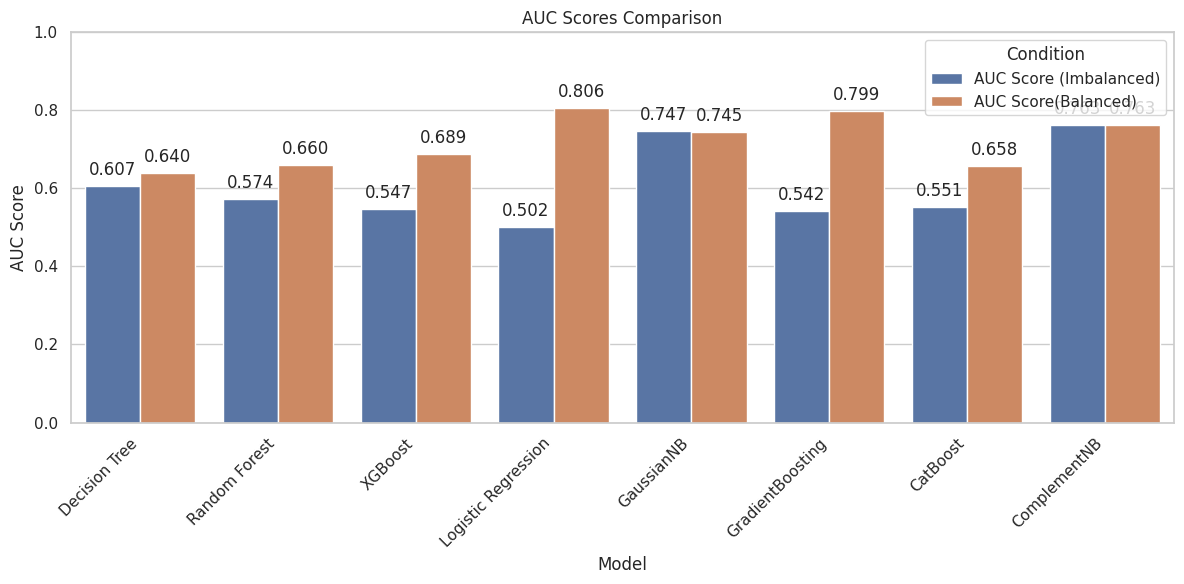

In [ ]:
#plotting the AUC score comparision of all the models

# Set the style of seaborn
sns.set(style="whitegrid")

# Melt the dataframe to combine the three AUC score columns into one
melted_data = final_comparision_df.melt(id_vars='Model', value_vars=['AUC Score (Imbalanced)', 'AUC Score(Balanced)'], var_name='Condition', value_name='AUC Score')

# Plot the bar graph
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Model', y='AUC Score', hue='Condition', data=melted_data)

# Add the AUC values on top of the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom',xytext=(0, 5),
                textcoords='offset points')

# Customize the plot
ax.set_title('AUC Scores Comparison')
ax.set_xlabel('Model')
ax.set_ylabel('AUC Score')
ax.set_ylim([0, 1])  # Set the y-axis limit to [0, 1] for AUC score

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Add a legend
plt.legend(title='Condition')

# Display the plot
plt.tight_layout()
plt.show()

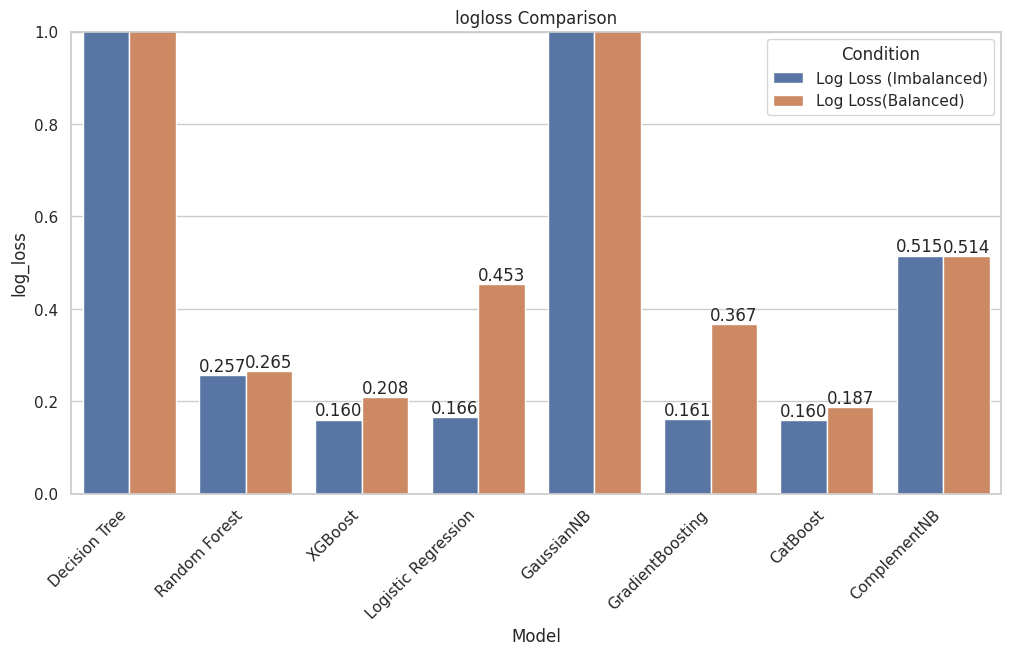

In [ ]:
#plotting the comparision of the logloss for all the models

# Set the style of seaborn
sns.set(style="whitegrid")

#Melt the dataframe to combine the three log loss columns into one
plot_data = final_comparision_df.melt(id_vars='Model', value_vars=['Log Loss (Imbalanced)','Log Loss(Balanced)'], var_name='Condition', value_name='Log Loss')

# Plot the bar graph
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Model', y='Log Loss', hue='Condition', data=plot_data)

# Add the log loss values on top of the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Customize the plot
ax.set_title('logloss Comparison')
ax.set_xlabel('Model')
ax.set_ylabel('log_loss')
ax.set_ylim([0, 1])  # Set the y-axis limit to [0, 1] for AUC score

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.legend(title='Condition')
plt.show()

## Exporting key components

In [ ]:
import os
from joblib import dump

# Get the current working directory
cwd = os.getcwd()

# Specify the relative path to the destination directory
destination = os.path.join(cwd, "key_comp")

# Create the "key_comp" directory if it doesn't exist
os.makedirs(destination, exist_ok=True)

# Export the imputer
num_imputer_filepath = os.path.join(destination, "numerical_imputer.joblib")
try:
    dump(numerical_imputer, num_imputer_filepath)
    print(f"Numerical Imputer exported to: {num_imputer_filepath}")
except Exception as e:
    print(f"Failed to export Numerical Imputer: {str(e)}")

cat_imputer_filepath = os.path.join(destination, "cat_imputer.joblib")
try:
    dump(cat_imputer, cat_imputer_filepath)
    print(f"Categorical Imputer exported to: {cat_imputer_filepath}")
except Exception as e:
    print(f"Failed to export Categorical Imputer: {str(e)}")

# Export the Encoder
encoder_filepath = os.path.join(destination, "encoder.joblib")
try:
    dump(encoder, encoder_filepath)
    print(f"Encoder exported to: {encoder_filepath}")
except Exception as e:
    print(f"Failed to export Encoder: {str(e)}")

# Export the scaler
scaler_filepath = os.path.join(destination, "scaler.joblib")
try:
    dump(scaler, scaler_filepath)
    print(f"Scaler exported to: {scaler_filepath}")
except Exception as e:
    print(f"Failed to export Scaler: {str(e)}")

# Export the models
lr_model_filepath = os.path.join(destination, "lr_smote_model.joblib")
try:
    dump(lr_smote_model, lr_model_filepath)
    print(f"Logistic Regression Model exported to: {lr_model_filepath}")
except Exception as e:
    print(f"Failed to export Logistic Regression Model: {str(e)}")

gb_model_filepath = os.path.join(destination, "gb_smote_model.joblib")
try:
    dump(gb_smote_model, gb_model_filepath)
    print(f"Gradient Boosting Model exported to: {gb_model_filepath}")
except Exception as e:
    print(f"Failed to export Gradient Boosting Model: {str(e)}")


Numerical Imputer exported to: /content/key_comp/numerical_imputer.joblib
Categorical Imputer exported to: /content/key_comp/cat_imputer.joblib
Encoder exported to: /content/key_comp/encoder.joblib
Scaler exported to: /content/key_comp/scaler.joblib
Logistic Regression Model exported to: /content/key_comp/lr_smote_model.joblib
Gradient Boosting Model exported to: /content/key_comp/gb_smote_model.joblib


In [ ]:
!pip list --format=freeze >key_comp/requirements.txt